<a href="https://colab.research.google.com/github/kiyong21c/kaggle/blob/main/20220720_plant-pathology-2020-in-pytorch_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 병든 잎사귀 식별
 - 미션 : 잎사귀 사진을 보고 잎사귀가 어떤 질병에 걸렸는지 식별
 - 유형 : 다중분류
 - 평가지표 : ROC AUC
 - 사용모델 : 사전 훈련 모델, 전이 학습, EfficientNet-B7, 스케줄러(학습률 갱신)
 - 훈련 : 교차 엔트로피 오차, AdamW
 - 예측 : 테스트 단계 데이터 증강 기법(TTA), 레이블 스무딩
 - 성능향상 기법 : Albumentations 이미지 변환기
  

 - 이진분류 : 타깃값이 0, 1
 - 다중분류 : 각 타깃값일 확률 예측

  > healthy : 건강한 잎사귀

  > multiplt_diseases : 여러 질병에 걸린 잎사귀

  > rust : 녹병에 걸린 잎사귀

  > scab : 붉은곰팡이병에 걸린 잎사귀

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 탐색적 데이터 분석
### 데이터 둘러보기

In [2]:
from zipfile import ZipFile
# 훈련 이미지 데이터 압축 풀기
with ZipFile('/content/drive/MyDrive/Colab Notebooks/kaggle/input/plan-pathology-2020-fgvc7/plant-pathology-2020-fgvc7.zip') as zipper:
    zipper.extractall() # zip파일이 있던 경로가 아닌 'content/train'에 압축이 해제됨

In [3]:
import pandas as pd

# 데이터 경로
data_path = '/content/'

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

In [4]:
train.shape, test.shape

((1821, 5), (1821, 1))

In [5]:
train.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0


 - image_id : 훈련 이미지 데이터의 파일명(확장자 미포함)
 - 나머지 피처 : 원-핫 인코딩 형식

In [6]:
test.head()

,image_id
0,Test_0
1,Test_1
2,Test_2
3,Test_3
4,Test_4


In [7]:
submission.head()

,image_id,healthy,multiple_diseases,rust,scab
0,Test_0,0.25,0.25,0.25,0.25
1,Test_1,0.25,0.25,0.25,0.25
2,Test_2,0.25,0.25,0.25,0.25
3,Test_3,0.25,0.25,0.25,0.25
4,Test_4,0.25,0.25,0.25,0.25


 - 제출 샘플파일은 일괄 25% 기재되어 있음

### 데이터 시각화

#### 타깃값 분포

In [8]:
# 데이터를 타깃값별로 추출
healthy = train.loc[train['healthy']==1] # df.loc[조건]  or df[조건]
multiple_diseases = train.loc[train['multiple_diseases']==1]
rust = train.loc[train['rust']==1]
scab = train.loc[train['scab']==1]

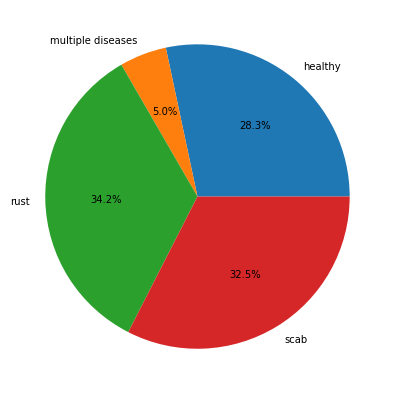

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))

label = ['healthy', 'multiple diseases', 'rust', 'scab']

plt.pie([len(healthy), len(multiple_diseases), len(rust), len(scab)],
        labels=label,
        autopct='%.1f%%');

 - 비율 차이가 커서 훈련/검증 데이터 나눌 때 비율 감안 필요

#### 이미지 출력

In [11]:
pip install opencv-python==4.5.5.64

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60.5 MB 1.2 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30


In [12]:
import matplotlib.gridspec as gridspec
import cv2

# 이미지 ID를 전달받아 출력하는 함수
def show_image(img_ids, rows=2, cols=3):
    assert len(img_ids) <= rows*cols # 이미지가 행*열 개수보다 많으면 오류발생
    
    plt.figure(figsize=(15, 8))
    grid = gridspec.GridSpec(rows, cols) # 서브플롯 배치 : grid[idx]로 축지정

    for idx, img_id in enumerate(img_ids):
        img_path = f'{data_path}images/{img_id}.jpg'
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax = plt.subplot(grid[idx])
        ax.imshow(image)

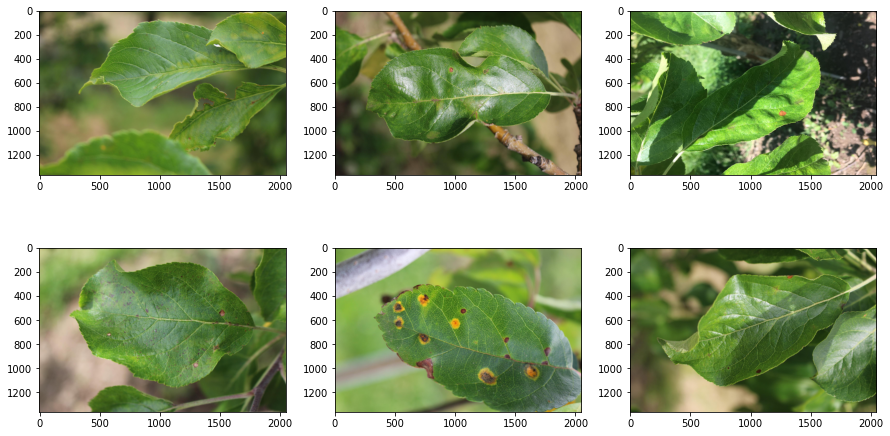

In [13]:
# last_healthy_img_ids = healthy['image_id'][-6:]
last_multiple_diseases_img_ids = multiple_diseases['image_id'][-6:]
show_image(last_multiple_diseases_img_ids)

## 베이스라인 모델
### 시드값 고정 및 GPU 장비 설정

In [14]:
import torch
import random
import numpy as np
import os

# 시드값 고정
## 이 모든 시드값 고정 코드가 반드시 필요한건 아니다(다른 환경에 다양하게 적용되도록 많은 시드 고정)
## 파이토치는 시드값 고정하더라도 해시값들에 의해 결과달라질수 있음
## 시드값 고정시 속도 저하 및 예측 성능 저하될 수 있음(결과를 재현할 필요 있을시에만 시드고정)
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)               # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)            # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)         # 파이토치 난수 생성기 시드 고정(CPU 사용시)
torch.cuda.manual_seed(seed)     # 파이토치 난수 생성기 시드 고정(GPU 사용시)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정(멀티GPU 사용시)
torch.backends.cudnn.deterministic= True    # 확정적 연산 사용
torch.backends.cudnn.benchmark= False       # 벤치마크 기능 해제
torch.backends.cudnn.enabled= False         # cudnn 사용 해제

#### GPU 장비 설정

In [15]:
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')

device

device(type='cuda')

### 데이터 준비

In [16]:
import pandas as pd

# 데이터 경로
data_path = '/content/'

train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
submission = pd.read_csv('/content/sample_submission.csv')

#### 훈련 및 검증 데이터 분리

In [17]:
from sklearn.model_selection import train_test_split

train, valid = train_test_split(train, test_size=0.1,
                                stratify=train[['healthy', 'multiple_diseases', 'rust', 'scab']], # stratify : target(배열형식)
                                random_state=50) 

#### 데이터셋 클래스 정의(오버라이딩)
 - 이미 정해져 있는 클래스(추상클래스) Dataset을 상속받아서 : super().\__init__\()
 -  \__init__\(), \__len__\(), \__getitem__\() 세가지 오버라이딩

In [18]:
import cv2
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스
import numpy as np

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None, is_test=False):
        super().__init__()
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
        self.is_test = is_test

    # 데이터셋(인스턴스) 크기 반환 메서드
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]               # 이미지 ID
        img_path = self.img_dir + img_id + '.jpg'   # 이미지 파일 경로
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 이미지 변환

        # 변환기가 있으면 이미지 데이터 변환적용
        if self.transform is not None:
            image = self.transform(image=image)['image'] # albumentations 모듈의 변환기 사용을 위한 형식 ['image']
        # 테스트 데이터면 → 이미지 데이터만 반환
        if self.is_test:
            return image
        # 훈련/검증용 데이터면 → 이미지 데이터 + 타깃값 반환
        else:
            # 타깃값 4개 중 가장 큰 값의 인덱스
            label = np.argmax(self.df.iloc[idx, 1:5])
            return image, label

#### 이미지 변환기 정의
 - albumentations가 제공하는 이미지 변환기
 - torchivsion 모듈에서 제공하는 이미지 변환기보다 빠르고 다양한 변환 제공

In [19]:
# module 'albumentations' has no attribute Error 발생시 github 통해서 설치
pip install git+https://github.com/albumentations-team/albumentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-4b6ajyux
  Running command git clone -q https://github.com/albumentations-team/albumentations /tmp/pip-req-build-4b6ajyux


In [20]:
# 이미지 변환을 위한 모듈 : ImportError 발생시 런타임 다시시작
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [22]:
# 훈련 데이터용 변환기
transform_train = A.Compose([A.Resize(450, 650),                                   # 이미지 크기 조절 (높이, 너비)
                             A.RandomBrightnessContrast(brightness_limit=0.2,       # 밝기 대비 조절
                                                        contrast_limit=0.2, p=0.3), # p : 적용확률
                             A.VerticalFlip(p=0.2),                                 # 상하 대칭 변환
                             A.HorizontalFlip(p=0.5),                               # 좌우 대칭 변환
                             A.ShiftScaleRotate(shift_limit=0.1,                    # 이동, 스케일링, 회전 변환
                                                scale_limit=0.2,
                                                rotate_limit=30, p=0.3),
                             A.OneOf([A.Emboss(p=1),                                # 양각화(Emboss), 날카로움, 블러 효과
                                      A.Sharpen(p=1),
                                      A.Blur(p=1)], p=0.3),
                             A.PiecewiseAffine(p=0.3),                              # 어파인 변환(이동, 확대/축소, 회전)
                             A.Normalize(),                                         # 정규화
                             ToTensorV2()])                                         # 텐서로 변환

In [23]:
# 검증 및 테스트 데이터용 변환기
transform_test = A.Compose([A.Resize(450, 650), # 크기는 당연히 훈련데이터와 맞춘다
                            A.Normalize(),      # 픽셀값 범위가 비슷해야(정규화) 비교가 쉽다
                            ToTensorV2()])      # 텐서로 변환

#### 데이터셋 및 데이터 로더 생성
 - 멀티프로세싱 활용 → 모델훈련 시간 단축
 - 데이터 로더는 전체 데이터에서 랜덤하게(설정시) 배치사이즈만큼 잘라서 오는데, 여러프로세스가 동시에 작업시 문제가 발생할 수도?
 - 조건 : 데이터 로더의 시드값 고정

  > seed_worker() 함수 정의

  > g = torch.Generator() 생성
  
  > g.manual_seed(0) 시드값 설정

  > DataLoader(**worker_init**=seed_worker, **generator**=g, **num_workers**=2)


In [26]:
# 데이터셋 정의(데이터셋 클래스의 인스턴스 생성)
img_dir = '/content/images/'

dataset_train = ImageDataset(train, img_dir=img_dir, transform=transform_train, is_test=False)
dataset_valid = ImageDataset(valid, img_dir=img_dir, transform=transform_test, is_test=False) # 검증용 데이터는 타깃값이 있으므로 False

In [ ]:
dataset_train[0] # train 데이터중 첫번째의 (이미지 데이터, 타깃값)
# dataset_train[0][0] # 이미지 데이터
# dataset_train[0][1] # 타깃값

In [ ]:
# seed_worker() 함수 정의
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
# 제너레이터 생성
g = torch.Generator()
# 시드값 설정
g.manual_seed(0) # 설정이후 부터는 torch.rand()해도 같은 값 나옴

In [ ]:
from torch.utils.data import DataLoader # 데이터 로더 생성을 위한 클래스

batch_size = 4 # 훈련데이터가 1821개로 많지 않아 배치크기 작게 설정

loader_train = DataLoader(dataset_train, batch_size=batch_size,
                          shuffle = True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)

loader_ = DataLoader(dataset_train, batch_size=batch_size,
                          shuffle = True, worker_init_fn=seed_worker,
                          generator=g, num_workers=2)